## Predicting Crime Categories

#### Import statements

In [103]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

#### Importing train data 

In [104]:
df_train_origin = pd.read_csv("train.csv")
print(df_train_origin.head())

                 Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.4387

#### Importing test data 

In [105]:
import pandas as pd

df_test_origin = pd.read_csv("test.csv")
#print(df_test_origin)

#### Information about the data

In [106]:
df_train_origin.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')

In [107]:
df_train_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


#### Detecting outliers

In [108]:
#GPS of San Francisco
#• Breitengrad von San Francisco:
    #37.7562
#• Längengrad von San Francisco:
    #-122.4430
#• GPS Koordinaten von San Francisco:
    #37° 45‘ 22.32 N 122° 26‘ 34.8 W

coordinates_range = ((df_train_origin.X.min(),   df_train_origin.X.max(),
         df_train_origin.Y.min(), df_train_origin.Y.max()))

print(coordinates_range)

sum = 0
for i in df_train_origin.index:
    if df_train_origin["Y"][i] > 37.9:
        sum +=1
print("sum of Y coordinates outside San Francisco: ", sum)

(-122.51364206429, -120.5, 37.7078790224135, 90.0)
sum of Y coordinates outside San Francisco:  67


In [74]:
#GPS of San Francisco
#• Breitengrad von San Francisco:
    #37.7562
#• Längengrad von San Francisco:
    #-122.4430
#• GPS Koordinaten von San Francisco:
    #37° 45‘ 22.32 N 122° 26‘ 34.8 W

coordinates_range = ((df_test_origin.X.min(),   df_test_origin.X.max(),
         df_test_origin.Y.min(), df_test_origin.Y.max()))

print(coordinates_range)

sum = 0
for i in df_test_origin.index:
    if df_test_origin["Y"][i] > 37.9:
        sum +=1
print("sum of Y coordinates outside San Francisco: ", sum)

(-122.51364206429, -120.5, 37.7078790224135, 90.0)
sum of Y coordinates outside San Francisco:  76


#### Cleaning data

In [109]:
#remove all records that are not located in San Francisco

df_train_origin = df_train_origin[df_train_origin["Y"] < 38]

df_test_origin = df_test_origin[df_test_origin["Y"] < 38]


#### Mapping of column category (as our "Y")

In [110]:
#all different categories
pd.unique(df_train_origin["Category"])

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [111]:
dict_category = {}
index = 1
for i in pd.unique(df_train_origin["Category"]):
    val = {i : index}
    dict_category.update(val)
    index+=1

print(dict_category)

{'WARRANTS': 1, 'OTHER OFFENSES': 2, 'LARCENY/THEFT': 3, 'VEHICLE THEFT': 4, 'VANDALISM': 5, 'NON-CRIMINAL': 6, 'ROBBERY': 7, 'ASSAULT': 8, 'WEAPON LAWS': 9, 'BURGLARY': 10, 'SUSPICIOUS OCC': 11, 'DRUNKENNESS': 12, 'FORGERY/COUNTERFEITING': 13, 'DRUG/NARCOTIC': 14, 'STOLEN PROPERTY': 15, 'SECONDARY CODES': 16, 'TRESPASS': 17, 'MISSING PERSON': 18, 'FRAUD': 19, 'KIDNAPPING': 20, 'RUNAWAY': 21, 'DRIVING UNDER THE INFLUENCE': 22, 'SEX OFFENSES FORCIBLE': 23, 'PROSTITUTION': 24, 'DISORDERLY CONDUCT': 25, 'ARSON': 26, 'FAMILY OFFENSES': 27, 'LIQUOR LAWS': 28, 'BRIBERY': 29, 'EMBEZZLEMENT': 30, 'SUICIDE': 31, 'LOITERING': 32, 'SEX OFFENSES NON FORCIBLE': 33, 'EXTORTION': 34, 'GAMBLING': 35, 'BAD CHECKS': 36, 'TREA': 37, 'RECOVERED VEHICLE': 38, 'PORNOGRAPHY/OBSCENE MAT': 39}


In [112]:
#maped column "Category"
Y_df = df_train_origin["Category"].map(dict_category).fillna(df_train_origin["Category"]).astype(int) # categories

#### Mapping of column weekday (as a part of "X")

In [113]:
#all different weekdays
pd.unique(df_train_origin["DayOfWeek"])

array(['Wednesday', 'Tuesday', 'Monday', 'Sunday', 'Saturday', 'Friday',
       'Thursday'], dtype=object)

In [114]:
#dict weekday
dict_weekday = {"Monday" : 1, "Tuesday" : 2, "Wednesday" : 3, "Thursday" : 4, "Friday" : 5, "Saturday" : 6, "Sunday" : 7 }
print(dict_weekday)

{'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}


In [115]:
#maped column "DayOfWeek"
weekdays = df_train_origin["DayOfWeek"].map(dict_weekday).fillna(df_train_origin["DayOfWeek"]).astype(int)

#### Mapping of column PdDistrict (as a part of "X")

In [116]:
#all different police department district
pd.unique(df_train_origin["PdDistrict"])

array(['NORTHERN', 'PARK', 'INGLESIDE', 'BAYVIEW', 'RICHMOND', 'CENTRAL',
       'TARAVAL', 'TENDERLOIN', 'MISSION', 'SOUTHERN'], dtype=object)

In [117]:
dict_PdDistrict = {}
index = 1
for i in pd.unique(df_train_origin["PdDistrict"]):
    val = {i : index}
    dict_PdDistrict.update(val)
    index+=1

print(dict_PdDistrict)

{'NORTHERN': 1, 'PARK': 2, 'INGLESIDE': 3, 'BAYVIEW': 4, 'RICHMOND': 5, 'CENTRAL': 6, 'TARAVAL': 7, 'TENDERLOIN': 8, 'MISSION': 9, 'SOUTHERN': 10}


In [118]:
#maped column "Category"
pdDistricts = df_train_origin["PdDistrict"].map(dict_PdDistrict).fillna(df_train_origin["PdDistrict"]).astype(int)

#### Mapping of all Resolutions (not realy useful so actually not a part of "X")

In [119]:
#all different Resolutions
pd.unique(df_train_origin["Resolution"])

array(['ARREST, BOOKED', 'NONE', 'ARREST, CITED', 'PSYCHOPATHIC CASE',
       'JUVENILE BOOKED', 'UNFOUNDED', 'EXCEPTIONAL CLEARANCE', 'LOCATED',
       'CLEARED-CONTACT JUVENILE FOR MORE INFO', 'NOT PROSECUTED',
       'JUVENILE DIVERTED', 'COMPLAINANT REFUSES TO PROSECUTE',
       'JUVENILE ADMONISHED', 'JUVENILE CITED',
       'DISTRICT ATTORNEY REFUSES TO PROSECUTE',
       'PROSECUTED BY OUTSIDE AGENCY', 'PROSECUTED FOR LESSER OFFENSE'],
      dtype=object)

In [120]:
dict_Resolutions = {}
index = 1
for i in pd.unique(df_train_origin["Resolution"]):
    val = {i : index}
    dict_Resolutions.update(val)
    index+=1

print(dict_Resolutions)

{'ARREST, BOOKED': 1, 'NONE': 2, 'ARREST, CITED': 3, 'PSYCHOPATHIC CASE': 4, 'JUVENILE BOOKED': 5, 'UNFOUNDED': 6, 'EXCEPTIONAL CLEARANCE': 7, 'LOCATED': 8, 'CLEARED-CONTACT JUVENILE FOR MORE INFO': 9, 'NOT PROSECUTED': 10, 'JUVENILE DIVERTED': 11, 'COMPLAINANT REFUSES TO PROSECUTE': 12, 'JUVENILE ADMONISHED': 13, 'JUVENILE CITED': 14, 'DISTRICT ATTORNEY REFUSES TO PROSECUTE': 15, 'PROSECUTED BY OUTSIDE AGENCY': 16, 'PROSECUTED FOR LESSER OFFENSE': 17}


In [121]:
#maped column "Resolution"
resolutions = df_train_origin["Resolution"].map(dict_Resolutions).fillna(df_train_origin["Resolution"]).astype(int)

#### Mapping of all descriptions (not realy useful so actually not a part of "X")

In [122]:
#all different Descriptions
pd.unique(df_train_origin["Descript"])

array(['WARRANT ARREST', 'TRAFFIC VIOLATION ARREST',
       'GRAND THEFT FROM LOCKED AUTO', 'GRAND THEFT FROM UNLOCKED AUTO',
       'STOLEN AUTOMOBILE', 'PETTY THEFT FROM LOCKED AUTO',
       'MISCELLANEOUS INVESTIGATION',
       'MALICIOUS MISCHIEF, VANDALISM OF VEHICLES', 'FOUND PROPERTY',
       'ROBBERY, ARMED WITH A KNIFE',
       'AGGRAVATED ASSAULT WITH BODILY FORCE', 'TRAFFIC VIOLATION',
       'ROBBERY, BODILY FORCE',
       'STAY AWAY OR COURT ORDER, NON-DV RELATED', 'LOST PROPERTY',
       'ATTEMPTED THEFT FROM LOCKED VEHICLE', 'CIVIL SIDEWALKS, CITATION',
       'MALICIOUS MISCHIEF, VANDALISM', 'SUSPICIOUS PACKAGE',
       'AIDED CASE, MENTAL DISTURBED', 'PETTY THEFT SHOPLIFTING',
       'PROBATION VIOLATION', 'STAY AWAY ORDER VIOLATION, DV RELATED',
       'DRIVERS LICENSE, SUSPENDED OR REVOKED', 'STOLEN MOTORCYCLE',
       'GRAND THEFT FROM PERSON', 'BURGLARY, VEHICLE (ARREST MADE)',
       'ATTEMPTED ROBBERY ON THE STREET WITH BODILY FORCE',
       'PETTY THEFT FROM A B

In [123]:
dict_Descriptions = {}
index = 1
for i in pd.unique(df_train_origin["Descript"]):
    val = {i : index}
    dict_Descriptions.update(val)
    index+=1

print(dict_Descriptions)

{'WARRANT ARREST': 1, 'TRAFFIC VIOLATION ARREST': 2, 'GRAND THEFT FROM LOCKED AUTO': 3, 'GRAND THEFT FROM UNLOCKED AUTO': 4, 'STOLEN AUTOMOBILE': 5, 'PETTY THEFT FROM LOCKED AUTO': 6, 'MISCELLANEOUS INVESTIGATION': 7, 'MALICIOUS MISCHIEF, VANDALISM OF VEHICLES': 8, 'FOUND PROPERTY': 9, 'ROBBERY, ARMED WITH A KNIFE': 10, 'AGGRAVATED ASSAULT WITH BODILY FORCE': 11, 'TRAFFIC VIOLATION': 12, 'ROBBERY, BODILY FORCE': 13, 'STAY AWAY OR COURT ORDER, NON-DV RELATED': 14, 'LOST PROPERTY': 15, 'ATTEMPTED THEFT FROM LOCKED VEHICLE': 16, 'CIVIL SIDEWALKS, CITATION': 17, 'MALICIOUS MISCHIEF, VANDALISM': 18, 'SUSPICIOUS PACKAGE': 19, 'AIDED CASE, MENTAL DISTURBED': 20, 'PETTY THEFT SHOPLIFTING': 21, 'PROBATION VIOLATION': 22, 'STAY AWAY ORDER VIOLATION, DV RELATED': 23, 'DRIVERS LICENSE, SUSPENDED OR REVOKED': 24, 'STOLEN MOTORCYCLE': 25, 'GRAND THEFT FROM PERSON': 26, 'BURGLARY, VEHICLE (ARREST MADE)': 27, 'ATTEMPTED ROBBERY ON THE STREET WITH BODILY FORCE': 28, 'PETTY THEFT FROM A BUILDING': 29, '

In [124]:
#maped column "Descriptions"
descriptions = df_train_origin["Descript"].map(dict_Descriptions).fillna(df_train_origin["Descript"]).astype(int)

#### Mapping of all addresses (as a part of "X", perhaps useful to factorize this differently)

In [125]:
#all different Addresses
pd.unique(df_train_origin["Address"]).size

23191

In [126]:
dict_Addresses = {}
index = 1
for i in pd.unique(df_train_origin["Address"]):
    val = {i : index}
    dict_Addresses.update(val)
    index+=1

#print(dict_Addresses)

In [127]:
#maped column "Descriptions"
addresses = df_train_origin["Address"].map(dict_Addresses).fillna(df_train_origin["Address"]).astype(int)

#### Converting Dates to timestamps (it is split into individual attributes for meaningful use)

In [128]:
df_train_origin.dtypes


Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

In [129]:
datetimes =  pd.to_datetime(df_train_origin['Dates'])
datetimes

0        2015-05-13 23:53:00
1        2015-05-13 23:53:00
2        2015-05-13 23:33:00
3        2015-05-13 23:30:00
4        2015-05-13 23:30:00
                 ...        
878044   2003-01-06 00:15:00
878045   2003-01-06 00:01:00
878046   2003-01-06 00:01:00
878047   2003-01-06 00:01:00
878048   2003-01-06 00:01:00
Name: Dates, Length: 877982, dtype: datetime64[ns]

#### Generating mapped dataFrame (as our "X)

In [130]:
data_new = { "DayOfWeek": weekdays,
            "PdDistrict": pdDistricts,  "Address": addresses,
            "X": df_train_origin["X"], "Y":df_train_origin["Y"] }
#"Resolution" : resolutions, "Descript": descriptions,

In [131]:
X_df = pd.DataFrame(data_new)
print(X_df)

        DayOfWeek  PdDistrict  Address           X          Y
0               3           1        1 -122.425892  37.774599
1               3           1        1 -122.425892  37.774599
2               3           1        2 -122.424363  37.800414
3               3           1        3 -122.426995  37.800873
4               3           2        4 -122.438738  37.771541
...           ...         ...      ...         ...        ...
878044          1           7    16121 -122.459033  37.714056
878045          1           3    13578 -122.447364  37.731948
878046          1          10     4418 -122.403390  37.780266
878047          1          10     2094 -122.390531  37.780607
878048          1           4    22078 -122.394926  37.738212

[877982 rows x 5 columns]


In [132]:
#splitting dates in different time features

L = ['year', 'month', 'day', 'dayofyear', 'week', 'quarter', 'hour']
print(L)
date_gen = (getattr(datetimes.dt, i).rename(i) for i in L)
print(date_gen)
print(X_df.columns)
X_df = X_df.join(pd.concat(date_gen, axis=1))

print(X_df)

['year', 'month', 'day', 'dayofyear', 'week', 'quarter', 'hour']
<generator object <genexpr> at 0x000001FB48CF1B30>
Index(['DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y'], dtype='object')


<ipython-input-132-e5d70989e10b>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  date_gen = (getattr(datetimes.dt, i).rename(i) for i in L)


        DayOfWeek  PdDistrict  Address           X          Y  year  month  \
0               3           1        1 -122.425892  37.774599  2015      5   
1               3           1        1 -122.425892  37.774599  2015      5   
2               3           1        2 -122.424363  37.800414  2015      5   
3               3           1        3 -122.426995  37.800873  2015      5   
4               3           2        4 -122.438738  37.771541  2015      5   
...           ...         ...      ...         ...        ...   ...    ...   
878044          1           7    16121 -122.459033  37.714056  2003      1   
878045          1           3    13578 -122.447364  37.731948  2003      1   
878046          1          10     4418 -122.403390  37.780266  2003      1   
878047          1          10     2094 -122.390531  37.780607  2003      1   
878048          1           4    22078 -122.394926  37.738212  2003      1   

        day  dayofyear  week  quarter  hour  
0        13      

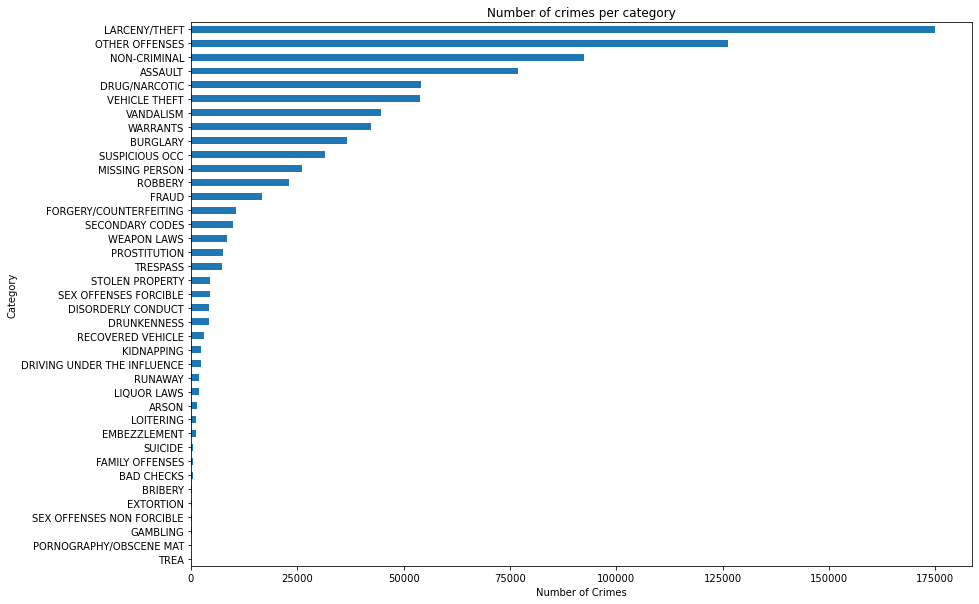

In [133]:
plt.figure(figsize=(14,10))
plt.title('Number of crimes per category')
plt.ylabel('Category')
plt.xlabel('Number of Crimes')


X_df.groupby([df_train_origin['Category']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

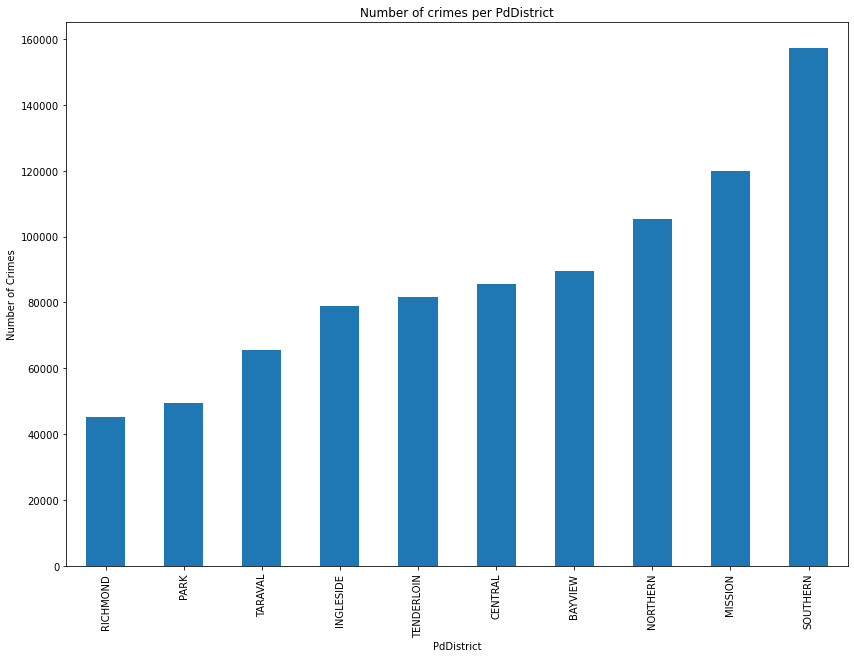

In [99]:
#Crimes per PdDistrict

plt.figure(2, figsize=(14,10))
plt.title('Number of crimes per PdDistrict')
plt.ylabel('Number of Crimes')
plt.xlabel('Weekday')


X_df.groupby([df_train_origin['PdDistrict']]).size().sort_values(ascending=True).plot(kind='bar')

plt.show()

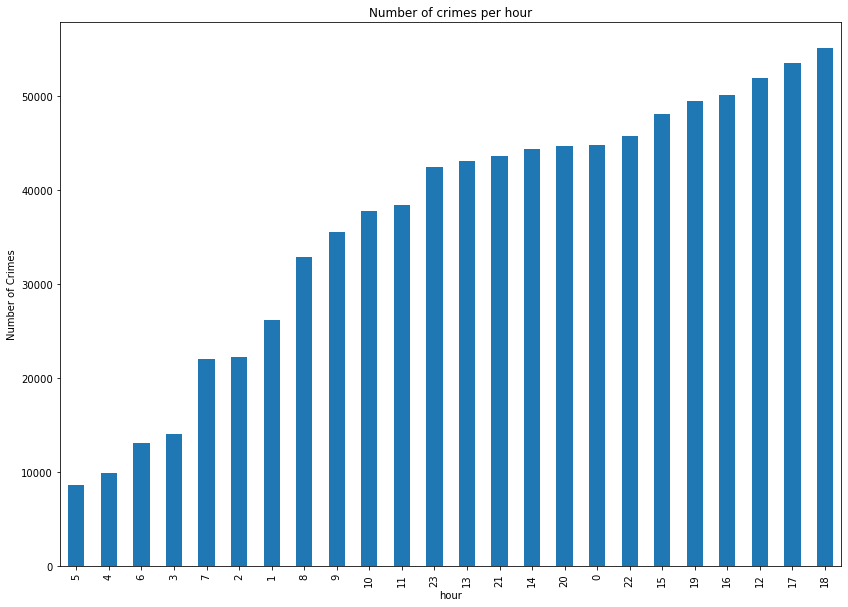

In [134]:
#Crimes per hour

plt.figure(3, figsize=(14,10))
plt.title('Number of crimes per hour')
plt.ylabel('Number of Crimes')
plt.xlabel('hour')


X_df.groupby([X_df['hour']]).size().sort_values(ascending=True).plot(kind='bar')

plt.show()

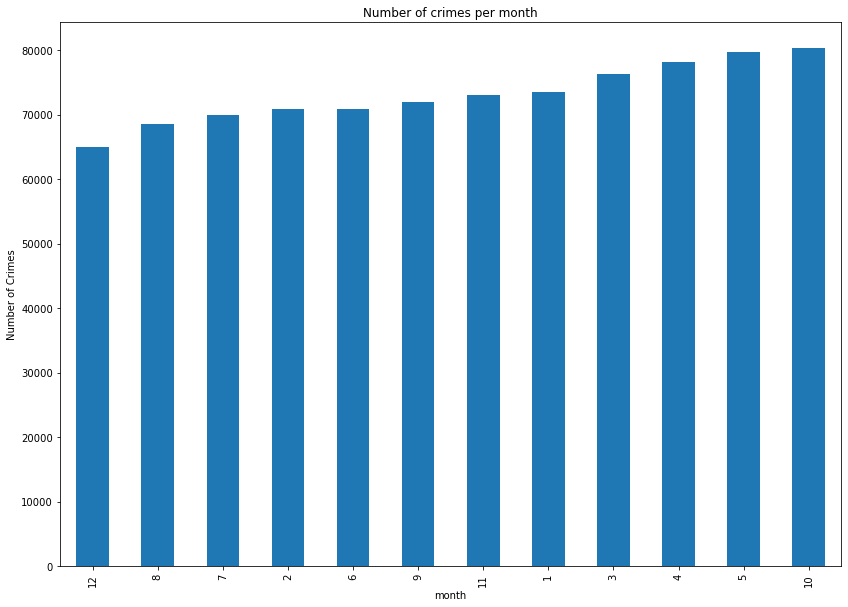

In [48]:
#Crimes per month
plt.figure(4, figsize=(14,10))
plt.title('Number of crimes per month')
plt.ylabel('Number of Crimes')
plt.xlabel('month')


X_df.groupby([X_df['month']]).size().sort_values(ascending=True).plot(kind='bar')

plt.show()

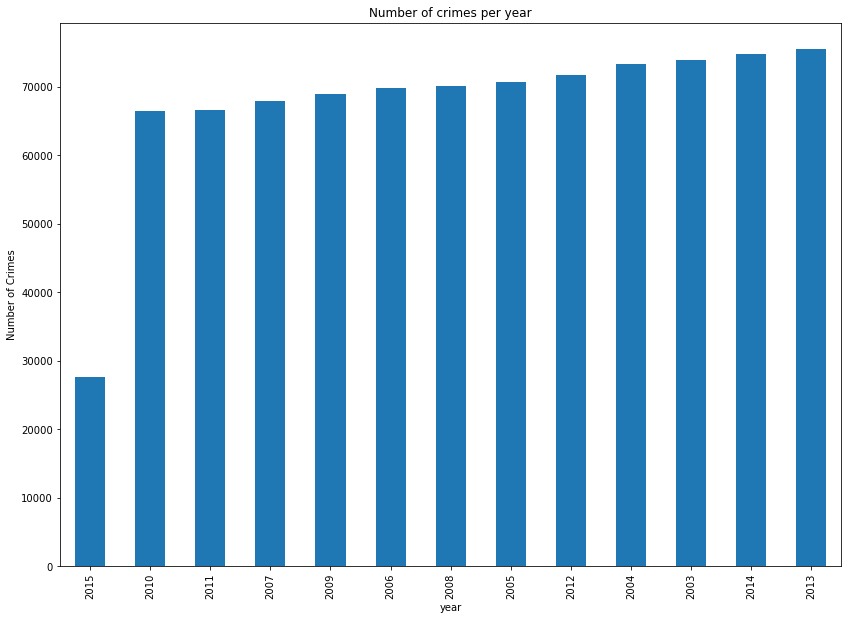

In [135]:
#Crimes per Year
plt.figure(4, figsize=(14,10))
plt.title('Number of crimes per year')
plt.ylabel('Number of Crimes')
plt.xlabel('year')


X_df.groupby([X_df['year']]).size().sort_values(ascending=True).plot(kind='bar')

plt.show()

#### Preparing the models
        

In [138]:
#Train- data split into train and test datasets

x_train, x_test, y_train, y_test = train_test_split(X_df, Y_df, train_size=0.8, random_state=0)